<a href="https://colab.research.google.com/github/AarnoStormborn/Tensorflow-Developer-Certification/blob/main/08_tensorflow_natural_language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow: Natural Language Processing

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f3a87e3e-6a98-00d3-37e9-789a290c9c71)


## Get Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-01 15:44:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-01 15:44:00 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a Text Dataset

Kaggle's Introductory NLP dataset: Disaster Tweets

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-06-01 15:44:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.130.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   721KB/s    in 0.8s    

2023-06-01 15:44:02 (721 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing Text dataset

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training data

train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_shuffled.head()

,id,keyword,location,text,target
0,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
1,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
4,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualize random samples
import random

random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}\t", "Disaster" if target==1 else "Not Disaster")
    print(f"Text:\n{text}\n")
    print("-------------------\n")

Target: 1	 Disaster
Text:
Setting things on fire is always an option

-------------------

Target: 0	 Not Disaster
Text:
I don't laugh out loud at many things. But man I really lol @ the big bang theory.

-------------------

Target: 0	 Not Disaster
Text:
RT: fittscott: Minecraft- NIGHT LUCKY BLOCK MOD (BOB APOCALYPSE WITHER 2.0 &amp; MORE!) Mod Showcase Popularmmos: http://t.co/MuL1J9AEUx viÛ_

-------------------

Target: 0	 Not Disaster
Text:
Bit pacquiao vs marquez 3 unfilled blazing swarm online: DuRvOd http://t.co/6VJA8R4YXA

-------------------

Target: 1	 Disaster
Text:
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/BHZr9UgUs2

-------------------



## Split train data into train and validation sets

In [11]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, random_state=42)
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((6851,), (762,), (6851,), (762,))

## Converting text into numbers

There are typically two methods to do this
* Tokenization: Direct mapping of text to numbers
* Embeddings: Creating a matrix of feature vector for each token

### Text Vectorization (Tokenization)

In [12]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace', ngrams=None,
                                    output_mode='int', 
                                    output_sequence_length=None) # length of output sequence

In [13]:
# Average tokens per sentence
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [14]:
# Setup text vectorization variables

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [15]:
# Fit the text vectorizere to the train sentences
text_vectorizer.adapt(train_sentences)

In [16]:
# Create a sample sentence and tokenize it
sample_sentence = ["There's a flood in my street"]
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [17]:
# Choose a random sentence from train sentences
random_sentence = random.choice(train_sentences)
print(f"Original Text: {random_sentence}\n\nVectorized:\n {text_vectorizer([random_sentence])}")

Original Text: Sinking carb consultative assembly plans could subconscious self live straight a leading way of escape: XkDrx

Vectorized:
 [[ 253    1    1 4129  645  137 7985  762  199 1252    3 1508  147    6
  1084]]


In [18]:
# Get the unique words in the vocabulary
words = text_vectorizer.get_vocabulary()
top_5_words = words[:5]
bottom_5_words = words[-5:]
print(f"Number of words: {len(words)}")
print(f"Top 5 words: {top_5_words}")
print(f"Bottom 5 words: {bottom_5_words}")

Number of words: 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding

Parameters in the Tensorflow Embedding layer
* `input_dim`: Size of vocabulary
* `output_dim`: Size of Output Embedding Vector
* `input_length`: Length of the Sequences

In [19]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=128,
                      input_length=max_length)
embedding

In [20]:
# Choose a random sentence from train sentences
random_sentence = random.choice(train_sentences)
print(f"Original Text: {random_sentence}\n\nEmbedding:\n)")

# Embed the random sentence
embed = embedding(text_vectorizer([random_sentence]))
embed

Original Text: @MelRises @gayler1969 @wwwbigbaldhead @jessienojoke @melissaross9847 if my Monty Python is up to date as bloody far as he wants to go.

Embedding:
)


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02937014,  0.03547696,  0.0487069 , ...,  0.015952  ,
          0.01727011,  0.02257972],
        [-0.02937014,  0.03547696,  0.0487069 , ...,  0.015952  ,
          0.01727011,  0.02257972],
        [-0.0225345 , -0.04637155,  0.01380743, ..., -0.02774192,
          0.03529287, -0.04371249],
        ...,
        [ 0.03687808,  0.04057062, -0.03326874, ...,  0.01518067,
          0.03241985,  0.00998881],
        [-0.02888264, -0.0013963 , -0.03765578, ...,  0.00790226,
          0.01952565,  0.04316868],
        [-0.00880303,  0.01191569,  0.03907007, ...,  0.00219318,
         -0.04894873, -0.0402531 ]]], dtype=float32)>

## Model Building for Text Datasets

Experiments to run:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-Forward Neural Network
* **Model 2**: LSTM model (RNN)
* **Model 3**: GRU model (RNN)
* **Model 4**: Bidirectional-LSTM model (RNN)
* **Model 5**: 1D Convolutional Neural Network (CNN)
* **Model 6**: TFHub Pretrained Feature Extractor
* **Model 7**: TFHub Pretrained Feature Extractor with 10% data

Standard Modelling steps:
* Create model
* Build model
* Fit model
* Evaluate model

### Model 0: Naive Bayes (Baseline)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Tokenization and Modelling Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline Accuracy: {baseline_score*100:.2f}%")

Baseline Accuracy: 79.27%


In [23]:
# Make predicitions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an Evaluation Function

In [24]:
# Evaluation function

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
        Calculate metrics for Binary Classification models
    """

    model_accuracy = accuracy_score(y_true, y_pred)

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {"accuracy": model_accuracy,
                     "precision": precision,
                     "recall": recall,
                     "f1_score": f1_score}
    
    return model_results

In [25]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

### Model 1: Feed-Forward Neural Network

In [26]:
# Create tensorbaord callback
from helper_functions import create_tensorboard_callback

# save dir for tensorboard logs
SAVE_DIR = "model_logs"

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Create model
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [28]:
# Compile model
model_1.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit model
history_1 = model_1.fit(train_sentences, train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_1")])

Saving TensorBoard log files to: model_logs/model_1/20230601-154407
Epoch 1/5
215/215 [==============================] - 18s 60ms/step - loss: 0.6087 - accuracy: 0.6976 - val_loss: 0.5360 - val_accuracy: 0.7520
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4400 - accuracy: 0.8202 - val_loss: 0.4704 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3455 - accuracy: 0.8624 - val_loss: 0.4580 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2822 - accuracy: 0.8915 - val_loss: 0.4646 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2361 - accuracy: 0.9121 - val_loss: 0.4832 - val_accuracy: 0.7861


In [29]:
# Evaluate model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4832 - accuracy: 0.7861


[0.48315465450286865, 0.7860892415046692]

In [30]:
# Make predictions
model_1_preds_prob = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_preds_prob))
model_1_preds[:10]

24/24 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [31]:
# Calculcate results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7860892388451444,
 'precision': 0.7925823788155513,
 'recall': 0.7860892388451444,
 'f1_score': 0.7825463664667974}

### Visualizing Learned Embeddings

In [32]:
# Get vocabulary
words = text_vectorizer.get_vocabulary()
len(words), words[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [33]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

Now we have the embeddings, we can use Tensorflow's Projector tool  \
https://projector.tensorflow.org/

In [34]:
# This code is taken from Tensorflow Word Embeddings token

# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [35]:
# Send files from Colab to Projector

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks

Learns Representations based on sequences. The features across a sequence are learned based on previous input.

* Andrej Karpathy - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* Chris Olah - https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### Model 2: Long Short Term Memory (LSTM)

Structure of RNN:
```
Input (text) -> Tokenize/Vectorize -> Embedding -> Layers (RNNs/Dense) -> Output (probability)
```

In [36]:
# Build model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return_sequences=True necessary when using multiple RNN layers (RNN need input of ndim=3 [batch, timesteps, features])
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs, outputs, name="model_2")
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                           

In [37]:
# Compile the model
model_2.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_2")])

Saving TensorBoard log files to: model_logs/model_2/20230601-154436
Epoch 1/5
215/215 [==============================] - 17s 56ms/step - loss: 0.2203 - accuracy: 0.9218 - val_loss: 0.6229 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1600 - accuracy: 0.9388 - val_loss: 0.6588 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1326 - accuracy: 0.9518 - val_loss: 0.6504 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1099 - accuracy: 0.9590 - val_loss: 0.8984 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0882 - accuracy: 0.9660 - val_loss: 1.0400 - val_accuracy: 0.7690


In [38]:
# Evaluate model
model_2.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.0400 - accuracy: 0.7690


[1.0399935245513916, 0.7690288424491882]

In [39]:
# Make predicitions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

24/24 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:
# Calculate results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.7690288713910761,
 'precision': 0.7706028054440214,
 'recall': 0.7690288713910761,
 'f1_score': 0.7669342344352704}

### Model 3: Gated Recurrent Unit (GRU)

In [41]:
# Build model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3 = Model(inputs, outputs, name="model_3")
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                           

In [42]:
# Compile the model
model_3.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_3")])

Saving TensorBoard log files to: model_logs/model_3/20230601-154521
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.1603 - accuracy: 0.9383 - val_loss: 0.6958 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0818 - accuracy: 0.9693 - val_loss: 0.8804 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0738 - accuracy: 0.9704 - val_loss: 0.9696 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0591 - accuracy: 0.9764 - val_loss: 0.9900 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0515 - accuracy: 0.9769 - val_loss: 1.2851 - val_accuracy: 0.7743


In [43]:
# Evaluate model
model_3.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 1.2851 - accuracy: 0.7743


[1.2851253747940063, 0.7742782235145569]

In [44]:
# Make predicitions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [45]:
# Calculate results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.7742782152230971,
 'precision': 0.7739610673665792,
 'recall': 0.7742782152230971,
 'f1_score': 0.7736832039282604}

### Model 4: Bidirectional RNN

In [46]:
# Build model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = Model(inputs, outputs, name="model_4")
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [47]:
# Compile the model
model_4.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_4 = model_4.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_4")])

Saving TensorBoard log files to: model_logs/model_4/20230601-154546
Epoch 1/5
215/215 [==============================] - 16s 55ms/step - loss: 0.1067 - accuracy: 0.9689 - val_loss: 1.0589 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0539 - accuracy: 0.9766 - val_loss: 1.1867 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0459 - accuracy: 0.9794 - val_loss: 1.4755 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.9787 - val_loss: 1.3317 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0402 - accuracy: 0.9797 - val_loss: 1.5226 - val_accuracy: 0.7598


In [48]:
# Evaluate model
model_4.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 1.5226 - accuracy: 0.7598


[1.5226417779922485, 0.7598425149917603]

In [49]:
# Make predicitions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

24/24 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [50]:
# Calculate results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7598425196850394,
 'precision': 0.7601337255372377,
 'recall': 0.7598425196850394,
 'f1_score': 0.7583542786286791}

## Convolutional Neural Networks for Sequential Data

Typical Structure of 1D CNN

```
Input (text) -> Tokenization -> Embedding -> Conv1D -> Pooling -> Output (probability)
```

In [51]:
# Test tokenization, embedding and Conv1D layers
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["This is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # 5 words at a time (n_gram of 5)
                        activation="relu",
                        padding="same") 
conv_1d_output = conv_1d(embedding_test)
gap = layers.GlobalAveragePooling1D()
gap_output = gap(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, gap_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

### Model 5: Conv1D

In [52]:
# Build model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = Model(inputs, outputs, name="model_5")
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 1)                 65  

In [53]:
# Compile the model
model_5.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_5 = model_5.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_5")])

Saving TensorBoard log files to: model_logs/model_5/20230601-154634
Epoch 1/5
215/215 [==============================] - 13s 50ms/step - loss: 0.1227 - accuracy: 0.9609 - val_loss: 0.9560 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0731 - accuracy: 0.9734 - val_loss: 1.0383 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0604 - accuracy: 0.9781 - val_loss: 1.1461 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0539 - accuracy: 0.9772 - val_loss: 1.2084 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0527 - accuracy: 0.9772 - val_loss: 1.2013 - val_accuracy: 0.7546


In [54]:
# Evaluate model
model_5.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 1.2013 - accuracy: 0.7546


[1.2013137340545654, 0.7545931935310364]

In [55]:
# Make predicitions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

24/24 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Calculate results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7545931758530183,
 'precision': 0.7541868955719352,
 'recall': 0.7545931758530183,
 'f1_score': 0.7538108030960206}

## Transfer Learning for NLP

* Universal Sentence Encoder (Tensorflow Hub)

In [57]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(sample_sentence)
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.02485911  0.02878049 -0.01271501  0.0397154   0.08827761
  0.02680985  0.05589838 -0.01068731 -0.0059729   0.00639323 -0.01819521
  0.00030817  0.09105889  0.05874642 -0.03180628  0.01512472 -0.05162928
  0.00991366 -0.06865346 -0.04209308  0.0267898   0.03011007  0.00321065
 -0.00337969 -0.04787356  0.02266722 -0.00985928 -0.04063612 -0.01292093
 -0.04666385  0.05630299 -0.03949254  0.00517688  0.02495828 -0.07014439
  0.02871511  0.04947681 -0.00633974 -0.08960193  0.02807117 -0.00808362
 -0.01360602  0.05998651 -0.10361787 -0.05195372  0.00232956 -0.02332529
 -0.03758107  0.0332773 ], shape=(50,), dtype=float32)


In [58]:
embed_samples.shape

TensorShape([1, 512])

In [59]:
# Create a KerasLayer using the pre-trained layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="use")

### Model 6: Universal Sentence Encoder

In [60]:
# Create model with Sequential API
from tensorflow.keras.models import Sequential

model_6 = Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_6.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Summary
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# Fit the model
history_6 = model_6.fit(train_sentences, train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_6")])

Saving TensorBoard log files to: model_logs/model_6/20230601-154755
Epoch 1/5
215/215 [==============================] - 6s 13ms/step - loss: 0.5107 - accuracy: 0.7786 - val_loss: 0.4493 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4156 - accuracy: 0.8168 - val_loss: 0.4377 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4031 - accuracy: 0.8209 - val_loss: 0.4331 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3952 - accuracy: 0.8248 - val_loss: 0.4302 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3899 - accuracy: 0.8272 - val_loss: 0.4268 - val_accuracy: 0.8123


In [62]:
# Evaluate model
model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 9ms/step - loss: 0.4268 - accuracy: 0.8123


[0.4267551600933075, 0.8123359680175781]

In [63]:
# Make predicitions
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

24/24 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [64]:
# Calculate results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8123359580052494,
 'precision': 0.8135161424410383,
 'recall': 0.8123359580052494,
 'f1_score': 0.8111730155404432}

In [65]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Create a Subset of Training data

Transfer Learning helps even with a smaller dataset. Therefore, we will run an experiment with USE, and provide it only 10% of the dataset

In [66]:
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

### Model 7: Transfer Learning with 10% data

In [67]:
# Build model 7 by cloning model 6
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss=BinaryCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Summary
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [68]:
# Fit the model
history_7 = model_7.fit(train_sentences_10_percent, train_labels_10_percent,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_7")])

Saving TensorBoard log files to: model_logs/model_7/20230601-154817
Epoch 1/5
24/24 [==============================] - 4s 41ms/step - loss: 0.6645 - accuracy: 0.7083 - val_loss: 0.6251 - val_accuracy: 0.7887
Epoch 2/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5934 - accuracy: 0.7963 - val_loss: 0.5490 - val_accuracy: 0.8031
Epoch 3/5
24/24 [==============================] - 1s 25ms/step - loss: 0.5217 - accuracy: 0.7976 - val_loss: 0.4833 - val_accuracy: 0.8045
Epoch 4/5
24/24 [==============================] - 1s 25ms/step - loss: 0.4664 - accuracy: 0.7989 - val_loss: 0.4404 - val_accuracy: 0.8202
Epoch 5/5
24/24 [==============================] - 0s 21ms/step - loss: 0.4302 - accuracy: 0.8213 - val_loss: 0.4097 - val_accuracy: 0.8320


In [69]:
# Evaluate model
model_7.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 9ms/step - loss: 0.4097 - accuracy: 0.8320


[0.40967661142349243, 0.8320209980010986]

In [70]:
# Make predicitions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.8320209973753281,
 'precision': 0.831933344290887,
 'recall': 0.8320209973753281,
 'f1_score': 0.831693372736778}

### Fix the Data Leakage problem

`model_7` outperforms `model_6`, even though the former only had 10% data. This is because
* During the data splitting, some validation sentences were sampled in the training sentences, hence creating a **Data Leakage** problem

In [72]:
# Check if any of the sentences are among both sets

any(train_sentences_10_percent) == any(val_sentences) 

True

In [73]:
# Create new training set
train_10_percent_split = int(0.1 * len(train_sentences))

train_sentences_10_percent_fixed = train_sentences[:train_10_percent_split]
train_labels_10_percent_fixed = train_labels[:train_10_percent_split]

len(train_sentences_10_percent_fixed), len(train_labels_10_percent_fixed)

(685, 685)

### Model 7 (Fixed)

* The model architecture remains the same, only data changes

In [74]:
# Fit the model
history_7 = model_7.fit(train_sentences_10_percent_fixed, train_labels_10_percent_fixed,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_7_corrected")])

Saving TensorBoard log files to: model_logs/model_7_corrected/20230601-154824
Epoch 1/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4691 - accuracy: 0.7752 - val_loss: 0.4020 - val_accuracy: 0.8399
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4357 - accuracy: 0.8044 - val_loss: 0.4013 - val_accuracy: 0.8373
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4062 - accuracy: 0.8131 - val_loss: 0.4038 - val_accuracy: 0.8333
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.3834 - accuracy: 0.8248 - val_loss: 0.4100 - val_accuracy: 0.8346
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.3665 - accuracy: 0.8394 - val_loss: 0.4162 - val_accuracy: 0.8241


In [75]:
# Evaluate model
model_7.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 10ms/step - loss: 0.4162 - accuracy: 0.8241


[0.4161938726902008, 0.8241469860076904]

In [76]:
# Make predicitions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

24/24 [==============================] - 0s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [77]:
# Calculate results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.8241469816272966,
 'precision': 0.8268202892990479,
 'recall': 0.8241469816272966,
 'f1_score': 0.8226499495437218}

In [78]:
# Check if any of the sentences are among both sets

any(train_sentences_10_percent_fixed) == any(val_sentences) 

True

In [79]:
for (train, val) in zip(train_sentences_10_percent_fixed, val_sentences):
    if train == val:
        print(train)

## Comapring Model Results

In [80]:
import pandas as pd

exp_results = {
    "baseline": baseline_results,
    "model_1": model_1_results,
    "model_2": model_2_results,
    "model_3": model_3_results,
    "model_4": model_4_results,
    "model_5": model_5_results,
    "model_6": model_6_results,
    "model_7": model_7_results,
}

df = pd.DataFrame(exp_results).T
df

,accuracy,precision,recall,f1_score
baseline,0.792651,0.811139,0.792651,0.786219
model_1,0.786089,0.792582,0.786089,0.782546
model_2,0.769029,0.770603,0.769029,0.766934
model_3,0.774278,0.773961,0.774278,0.773683
model_4,0.759843,0.760134,0.759843,0.758354
model_5,0.754593,0.754187,0.754593,0.753811
model_6,0.812336,0.813516,0.812336,0.811173
model_7,0.824147,0.826820,0.824147,0.822650


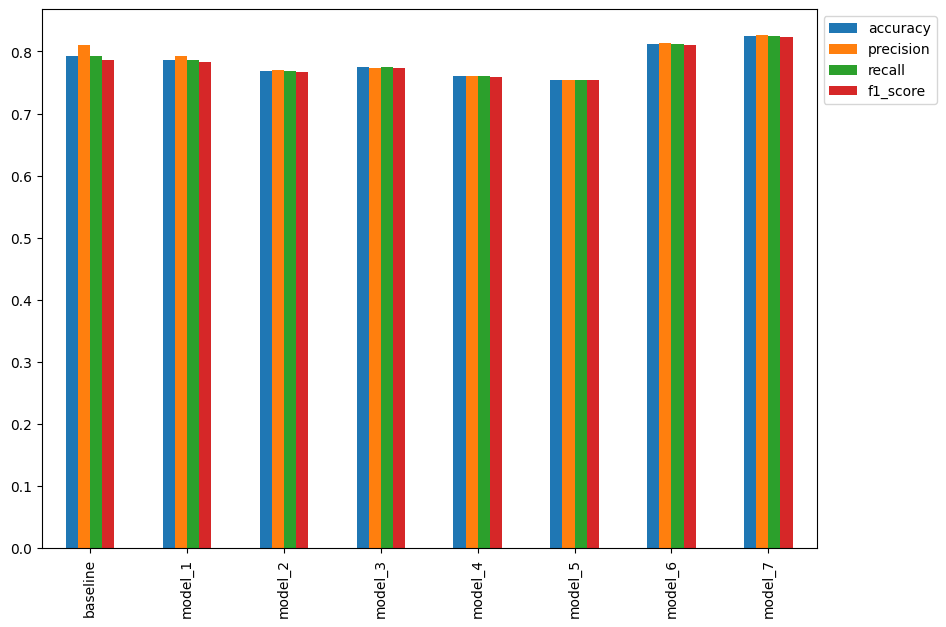

In [81]:
df.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

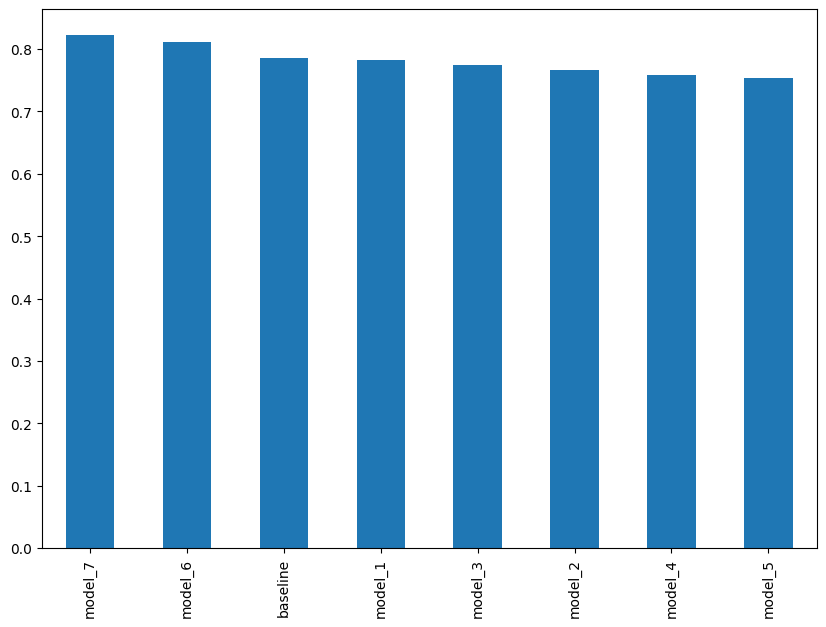

In [82]:
# Sort model results by f1-score
df.sort_values("f1_score", ascending=False)["f1_score"].plot(kind="bar", figsize=(10,7))

## Save and Load the best model

Two formats to store model in Tensorflow:
1. HDF5 format
2. `SavedModel` format

In [83]:
# Save model 6 (Transfer Learning)
model_6.save("model_6.h5")

In [84]:
# Load model 6 with Keras Layer (required for hdf5)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [85]:
# Evaluation of loaded model
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4268 - accuracy: 0.8123


[0.4267551600933075, 0.8123359680175781]

## Finding the most wrong examples

In [86]:
# Download Pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-06-01 15:48:43--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  19.6MB/s    in 48s     

2023-06-01 15:49:32 (18.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.inde

In [88]:
model = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [89]:
# Evaluate model
model.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [90]:
# Make predicitions
model_pred_probs = model.predict(val_sentences)
model_pred = tf.squeeze(tf.round(model_pred_probs))
model_pred[:10]

24/24 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [101]:
# Create DataFrame with val labels and predicitons
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_pred,
                       "probs": tf.squeeze(model_pred_probs)})
val_df.head()

,text,target,pred,probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [102]:
val_df.shape

(762, 4)

In [104]:
errors_df = val_df[val_df["target"] != val_df["pred"]].sort_values("probs", ascending=False).reset_index(drop=True)
errors_df.head(10)

,text,target,pred,probs
0,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
1,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
2,@noah_anyname That's where the concentration c...,0,1.0,0.852300
3,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
4,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
5,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
6,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
7,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
8,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
9,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [105]:
errors_df.tail(10)

,text,target,pred,probs
130,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
131,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
132,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
133,going to redo my nails and watch behind the sc...,1,0.0,0.054597
134,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
135,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
136,I get to smoke my shit in peace,1,0.0,0.042087
137,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
138,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
139,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


### Visualizing the most wrong examples

In [107]:
# False Positives
for row in errors_df[:10].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}\tPrediction: {pred}\t Probability: {prob}")
    print(f"Text:\n{text}")
    print(f"================================\n")

Target: 0	Prediction: 1.0	 Probability: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

Target: 0	Prediction: 1.0	 Probability: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

Target: 0	Prediction: 1.0	 Probability: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

Target: 0	Prediction: 1.0	 Probability: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

Target: 0	Prediction: 1.0	 Probability: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

Target: 0	Prediction: 1.0	 Probability: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly bu

In [108]:
# False Negatives
for row in errors_df[-10:].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}\tPrediction: {pred}\t Probability: {prob}")
    print(f"Text:\n{text}")
    print(f"================================\n")

Target: 1	Prediction: 0.0	 Probability: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

Target: 1	Prediction: 0.0	 Probability: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

Target: 1	Prediction: 0.0	 Probability: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

Target: 1	Prediction: 0.0	 Probability: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

Target: 1	Prediction: 0.0	 Probability: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

Target: 1	Prediction: 0.0	 Probability: 0.04391848295927048
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn s